In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import statistics
import math
from tqdm import tqdm
from operator import itemgetter
import pytesseract
import time
pytesseract.pytesseract.tesseract_cmd= r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [2]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height-1):
        for j in range(0, width-1):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
    return connected_components

In [3]:
###Skew estimation
doc = cv.imread('doc_4.png', 0)
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
doc_bin = 255 - doc_bin #convert black/white to white/bla


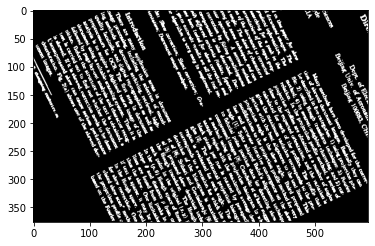

In [4]:
num_labels, labels_im = cv.connectedComponents(doc_bin)
connected_components = ExtractConnectedComponents(num_labels, labels_im)
plt.imshow(doc_bin, 'gray')


In [5]:
def Select_Candidate_Points(doc_bin, connected_components, mode):
    candidate_list = []
    for component in tqdm(connected_components):
            if (mode == 1): #Foregroud pixels
                for i in range(0, len(component)):
                    x = component[i][0]
                    y = component[i][1]
                    if (doc_bin[y,x] == 255):
                        candidate_list.append([x,y])
    
            elif (mode == 2): #Center of connected components
                x_sum = 0
                y_sum = 0
                for i in range(0, len(component)):
                    x_sum += component[i][0]
                    y_sum += component[i][1]
                if (len(component) != 0):
                    x = int(x_sum / len(component))
                    y = int(y_sum / len(component))
                candidate_list.append([x,y])

            elif (mode == 3): #Max coordinate for y axis
                if (len(component) != 0):
                    max_y_index = component.index(max(component, key=itemgetter(1)))
                    x = component[max_y_index][0]
                    y = component[max_y_index][1]
                    candidate_list.append([x,y])

            else:
                print ("Invalid mode")
                break

    return candidate_list




#### Task 2.1: Candidate point selection

In [6]:
start = time.time()
candidate_list_mode1 = Select_Candidate_Points(doc_bin, connected_components, 1) #Foreground pixels
time1 = time.time() - start
print ("Mode 1 time: ", time1)

start = time.time()
candidate_list_mode2 = Select_Candidate_Points(doc_bin, connected_components, 2) #Center of connected components
time2 = time.time() - start
print ("Mode 2 time: ", time2)

start = time.time()
candidate_list_mode3 = Select_Candidate_Points(doc_bin, connected_components, 3) #Max Y
time3 = time.time() - start
print ("Mode 3 time: ", time3)

#candidate_list_mode4 = Select_Candidate_Points(doc_bin, connected_components, 4) #Invalid Test

100%|█████████████████████████████████████████████████████████████████████████████| 646/646 [00:00<00:00, 23134.17it/s]

Mode 1 time:  0.5675961971282959
Mode 2 time:  0.0718376636505127
Mode 3 time:  0.029889822006225586


#### Functions required for further steps and document recognition system

In [7]:
def Remove_Non_Candidate_Points(doc_bin, candidate_list):
    ret_img = np.zeros((doc_bin.shape[0], doc_bin.shape[1]), dtype = "uint8")
    height, width = doc_bin.shape
    for point in candidate_list:
        ret_img[point[1], point[0]] = doc_bin[point[1], point[0]]
        #ret_img[point] = doc_bin[point]
    return ret_img


In [8]:
def GetSkewAngle(negative_image, density_threshold):
    distance_resolution = 1
    angular_resolution = (math.pi/180)
    lines = cv.HoughLines(negative_image, distance_resolution, angular_resolution, density_threshold)
    angles_list = []
    if lines is None:
        return None
    for k in range(0,len(lines)):
        distance, angle = lines[k][0]
        angles_list.append(angle)
    mean_angle = statistics.median(angles_list)
    return mean_angle

In [9]:
# rotate image
def DeskewImage(doc, mean_angle):
    height, width = doc.shape
    c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
    c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
    c = (c_x, c_y) # A point is defined by x and y coordinate
    deg_angle = mean_angle * 180.0 / math.pi
    deg_angle = 90 - deg_angle
    M = cv.getRotationMatrix2D(c, -deg_angle, 1) 
    doc_deskewed = cv.warpAffine(doc, M, (width, height))
    print("Angle in degrees: ", deg_angle)
    return doc_deskewed

In [10]:
def Save_Img_PDF(doc_deskewed, filename):
    text = pytesseract.image_to_string(doc_deskewed)
    pdf = pytesseract.image_to_pdf_or_hocr(doc_deskewed, extension="pdf")
    print(text)
    cv.imwrite(filename + "_deskewed.jpg", doc_deskewed)
    with open(filename + '.pdf', 'w+b') as f:
        f.write(pdf)
    return pdf

#### Task 2.2: Ablation Study to test density threshold parameter

In [11]:
negative_image_mode1 = Remove_Non_Candidate_Points(doc_bin, candidate_list_mode1)
negative_image_mode2 = Remove_Non_Candidate_Points(doc_bin, candidate_list_mode2)
negative_image_mode3 = Remove_Non_Candidate_Points(doc_bin, candidate_list_mode3)

cv.imwrite('doc_negative_mode1.png', negative_image_mode1)
cv.imwrite('doc_negative_mode2.png', negative_image_mode2)
cv.imwrite('doc_negative_mode3.png', negative_image_mode3)

mean_angle_mode1_10 = GetSkewAngle(negative_image_mode1, 10) 
mean_angle_mode2_10 = GetSkewAngle(negative_image_mode2, 10) 
mean_angle_mode3_10 = GetSkewAngle(negative_image_mode3, 10) 

mean_angle_mode1_500 = GetSkewAngle(negative_image_mode1, 15)
mean_angle_mode2_500 = GetSkewAngle(negative_image_mode2, 15)
mean_angle_mode3_500 = GetSkewAngle(negative_image_mode3, 15)

mean_angle_mode1_240 = GetSkewAngle(negative_image_mode1, 5)
mean_angle_mode2_240 = GetSkewAngle(negative_image_mode2, 5)
mean_angle_mode3_240 = GetSkewAngle(negative_image_mode3, 5)
print("Angles fo thresh: 10", mean_angle_mode1_10, mean_angle_mode2_10, mean_angle_mode3_10)
print("Angles fo thresh: 15", mean_angle_mode1_500, mean_angle_mode2_500, mean_angle_mode3_500)
print("Angles fo thresh: 5", mean_angle_mode1_240, mean_angle_mode2_240, mean_angle_mode3_240)


Angles fo thresh: 10 1.3089969158172607 None 1.5707964
Angles fo thresh: 15 1.3089969158172607 None 1.3439035415649414
Angles fo thresh: 5 1.3264502 1.9198622 1.780235767364502


In [12]:
doc_deskewed_mode1_10 = DeskewImage(doc, mean_angle_mode1_10)
#doc_deskewed_mode2_10 = DeskewImage(doc, mean_angle_mode2_10)
doc_deskewed_mode3_10 = DeskewImage(doc, mean_angle_mode3_10)

doc_deskewed_mode1_500 = DeskewImage(doc, mean_angle_mode1_500)
#doc_deskewed_mode2_500 = DeskewImage(doc, mean_angle_mode2_500)
doc_deskewed_mode3_500 = DeskewImage(doc, mean_angle_mode3_500)

doc_deskewed_mode1_240 = DeskewImage(doc, mean_angle_mode1_240)
doc_deskewed_mode2_240 = DeskewImage(doc, mean_angle_mode2_240)
doc_deskewed_mode3_240 = DeskewImage(doc, mean_angle_mode3_240)

Angle in degrees:  15.000001328029441
Angle in degrees:  -2.5044781608585254e-06
Angle in degrees:  15.000001328029441
Angle in degrees:  12.999998995644646
Angle in degrees:  14.00000016183705
Angle in degrees:  -19.99999850756943
Angle in degrees:  -11.999996008219426


#### Visualizing to check the best parameter and saving best result

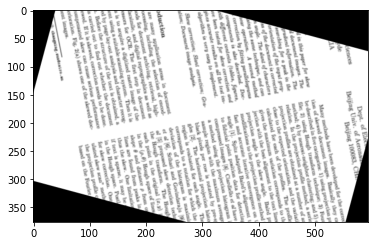

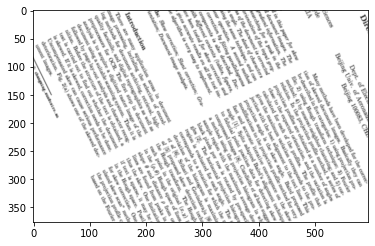

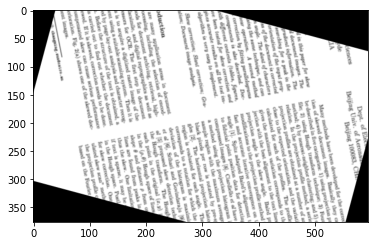

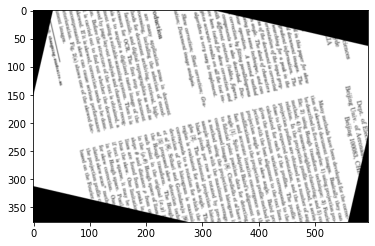

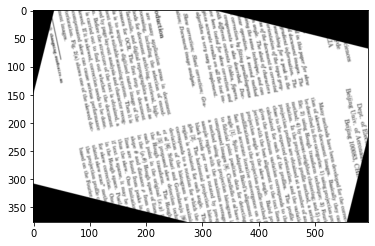

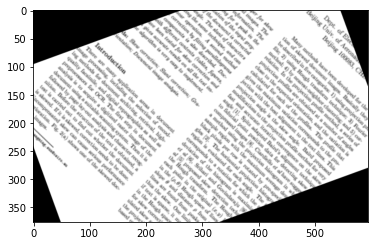

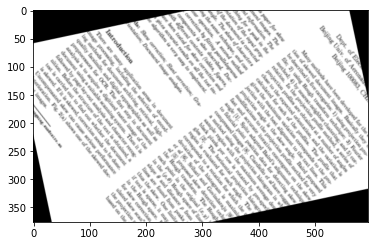

In [13]:
plt.imshow(doc_deskewed_mode1_10, 'gray')
plt.show()
#plt.imshow(doc_deskewed_mode2_10, 'gray')
#plt.show()
plt.imshow(doc_deskewed_mode3_10, 'gray')
plt.show()

plt.imshow(doc_deskewed_mode1_500, 'gray')
plt.show()
#plt.imshow(doc_deskewed_mode2_500, 'gray')
#plt.show()
plt.imshow(doc_deskewed_mode3_500, 'gray')
plt.show()

plt.imshow(doc_deskewed_mode1_240, 'gray')
plt.show()
plt.imshow(doc_deskewed_mode2_240, 'gray')
plt.show()
plt.imshow(doc_deskewed_mode3_240, 'gray')
plt.show()

#### We can see from visual inspection as well as text recognition that density threshold of 15 has the best results.
#### Also, as for density = 15 the accuracy for candidate startegies are similar so I choose the fastest (mode3) as the best result 

In [14]:
doc_text = pytesseract.image_to_string(doc)
doc_pdf = Save_Img_PDF(doc, "doc_orig")

PSN YAN AAS 3

WO \ \\ AAS ‘ae

\ SAN \ we Coe oh
VS A AS ag 7



In [15]:
doc_mode3_pdf = Save_Img_PDF(doc_deskewed_mode3_500, "doc_mode3")

In [16]:
doc_mode1_pdf = Save_Img_PDF(doc_deskewed_mode1_500, "doc_mode1")
doc_mode2_pdf = Save_Img_PDF(doc_deskewed_mode2_500, "doc_mode2")

NameError: name 'doc_deskewed_mode2_500' is not defined

### Task 3 and 4

#### As the accuracy of mode 2 and mode 3 candidate selection strategies are similar we choose the fastetst strategy i.e: choosing the maximum y coordinate from each connected components (mode 3)

#### This is used for testing against custom dataset and creating end to end document recognition system

In [ ]:
#Constant parameters based on ablation study
mode = 2
threshold = 200
density_threshold = 10

def Document_Recognition(doc, filename):    
    ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
    doc_bin = 255 - doc_bin #convert black/white to white/black
    
    num_labels, labels_im = cv.connectedComponents(doc_bin)
    connected_components = ExtractConnectedComponents(num_labels, labels_im)
    
    candidate_list = Select_Candidate_Points(doc_bin, connected_components, mode)
    if len(candidate_list) == 0:
        return None
    negative_image = Remove_Non_Candidate_Points(doc_bin, candidate_list)
    mean_angle = GetSkewAngle(negative_image, density_threshold)
    if mean_angle is None:
        return None
    doc_deskewed = DeskewImage(doc, mean_angle)
    pdf = Save_Img_PDF(doc_deskewed, filename)
    return pdf

In [ ]:
import glob
import os
#Replace with path to dataset dir
dataset_path = "C:\\Users\\singh\\Documents\\MastersAppliedAIDeakin\\SIT789_CompVision_SpeechProcessing\\Practicals\\data_2_3\\"
files = glob.glob(dataset_path + "*")
for img_name in files:
    base = os.path.basename(img_name)
    filename = os.path.splitext(base)[0]
    print (img_name, filename)
    img = cv.imread(img_name, 0)
    print (img.shape)
    Document_Recognition(img, filename)